# Image Classifier

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I'll train an image classifier to recognize different species of flowers. We can imagine using something like this in a phone app that tells us the name of the flower our camera is looking at. In practice I'd train this classifier, then export it for use in the application. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories. See a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use the trained model to perform inference on flower images.


When I've completed this project, I'll have an application that can be trained on any set of labeled images.

## Import Resources

In [1]:
# The new version of dataset is only available in the tfds-nightly package.
# %pip --no-cache-dir install  tfds-nightly --user
# %pip --no-cache-dir install tensorflow-datasets --user
# %pip --no-cache-dir install tensorflow==2.1.0 --user
# DON'T MISS TO RESTART THE KERNEL

In [2]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [3]:
# Make all other necessary imports.
import json
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

## Load the Dataset

Here I'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  I'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but I'll still need to normalize and resize the images to the appropriate size.

In [4]:
# Download data to default local directory "~/tensorflow_datasets"
!python3 -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_flowers102

In [5]:
# Load the dataset with TensorFlow Datasets. Hint: use tfds.load()
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True, download=True)

#, data_dir="~/tensorflow_datasets/oxford_flowers102/2.1.1

#  Create a training set, a validation set and a test set.
train, validation, test = dataset['train'], dataset['validation'], dataset['test']

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


## Explore the Dataset

In [6]:
# The number of examples in each set from the dataset info.

train_samples = 0
for data in train:
    train_samples += 1
print('Training Data has samples:' , train_samples)

validation_samples = 0
for data in validation:
    validation_samples += 1
print('Validation Data has samples:' , validation_samples)

test_samples = 0
for data in test:
    test_samples += 1
print('Testing Data has samples:' , test_samples)

# The number of classes in the dataset from the dataset info.
no_of_classes = dataset_info.features['label'].num_classes
print('Data has number of classes:' ,no_of_classes)

Training Data has samples: 1020
Validation Data has samples: 1020
Testing Data has samples: 6149
Data has number of classes: 102


In [7]:
#  Print the shape and corresponding label of 3 images in the training set.
i = 0
for data in train.take(3):
    i += 1 
    print('Image: ', i)
    print('Shape of the image is: ', data[0].shape)
    print('Image has label: {}'.format(data[1]))
    print('\n')

Image:  1
Shape of the image is:  (500, 667, 3)
Image has label: 72


Image:  2
Shape of the image is:  (500, 666, 3)
Image has label: 84


Image:  3
Shape of the image is:  (670, 500, 3)
Image has label: 70




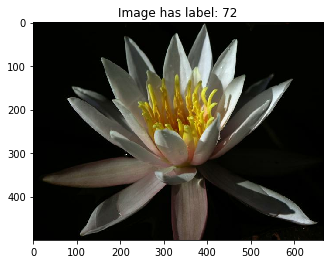

In [8]:
# Plot 1 image from the training set. 
# Set the title of the plot to the corresponding image label. 
for data in train.take(1):
    image = data[0].numpy()
    plt.figure()
    plt.imshow(image)
    plt.title('Image has label: {}'.format(data[1]))
    plt.show()

### Label Mapping

I'll also need to load in a mapping from label to category name. look at the file `label_map.json`.

In [9]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

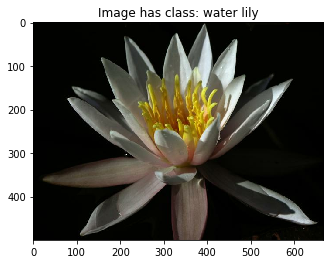

In [10]:
# Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for data in train.take(1):
    image = data[0].numpy()
    classname = class_names[str(data[1].numpy()+1)] 
    plt.figure()
    plt.imshow(image)
    plt.title('Image has class: {}'.format(classname))
    plt.show()

## Create Pipeline

In [11]:
# Create a pipeline for each set.
IMAGE_SIZE = 224
BATCH_SIZE = 32

def prepare_image(image, label):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) #resizing
    image = image/255.0 #normalizing
    return image, label

#creating training batch
train_batches = train.shuffle(train_samples//4).map(prepare_image).batch(BATCH_SIZE).prefetch(1)
#creating validation batch
validation_batches = validation.map(prepare_image).batch(BATCH_SIZE).prefetch(1)
#creating testing batch
test_batches = test.map(prepare_image).batch(BATCH_SIZE).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier.

In [12]:
# Build and train your network.
from tensorflow.keras import layers

#se the MobileNet pre-trained model from TensorFlow Hub to get the features
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze the Pre-Trained Model
feature_extractor.trainable = False

# Attach a classification model
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(no_of_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_batches,
                    epochs=20,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/20
32/32 [==============================] - 105s 3s/step - loss: 4.6041 - accuracy: 0.0618 - val_loss: 4.5429 - val_accuracy: 0.2039
Epoch 2/20
32/32 [==============================] - 101s 3s/step - loss: 4.4178 - accuracy: 0.3539 - val_loss: 4.3627 - val_accuracy: 0.4245
Epoch 3/20
32/32 [==============================] - 101s 3s/step - loss: 4.1943 - accuracy: 0.5833 - val_loss: 4.2351 - val_accuracy: 0.5627
Epoch 4/20
32/32 [==============================] - 100s 3s/step - loss: 4.0367 - accuracy: 0.7049 - val_loss: 4.1598 - val_accuracy: 0.6314
Epoch 5/20
32/32 [==============================] - 101s 3s/step - loss: 3.9501 - accuracy: 0.7745 - val_loss: 4.1155 - val_accuracy: 0.6676
Epoch 6/20
32/32 [==============================] - 100s 3s/step - loss: 3.8870 - accuracy: 0.8206 - val_loss: 4.0864 - val_accuracy: 0.6814
Epoch 7/20
32/32 [==============================] - 101s 3s/step - loss: 3.8450 - accuracy: 0.8490 - val_loss: 4.0660 - val_accuracy: 0.7010
Epoch 8/20
32

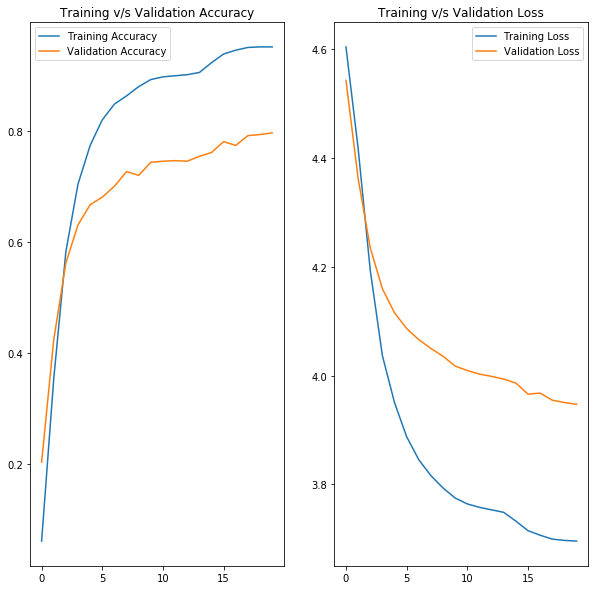

In [14]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(20)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training v/s Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training v/s Validation Loss')
plt.show()

## Testing your Network



In [15]:
# Print the loss and accuracy values achieved on the entire test set.
test_loss, test_accuracy = model.evaluate(test_batches)
print('Testing Loss {}, Testing Accuracy {}:'.format(test_loss, test_accuracy))

    193/Unknown - 302s 2s/step - loss: 3.9733 - accuracy: 0.7587Testing Loss 3.9733314612986512, Testing Accuracy 0.7586599588394165:


## Save the Model

Now that the network is trained, save the model so I can load it later for making inference.

In [16]:
# Save the trained model as a Keras model.
model.save('./model.h5')

## Load the Keras Model

Load the Keras model you saved above.

In [17]:
# Load the Keras model
keras_model = tf.keras.models.load_model('./model.h5',custom_objects={'KerasLayer':hub.KerasLayer})

# Inference for Classification



### Image Pre-processing



In [18]:
# Create the process_image function
def process_image(image):
    image=tf.convert_to_tensor(image,tf.float32)
    image=tf.image.resize(image, (224, 224))
    image/=255
    image= image.numpy()
    return image

Checked the `process_image` function with  4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by the `process_image` function. If the `process_image` function works, the plotted image should be the correct size. 

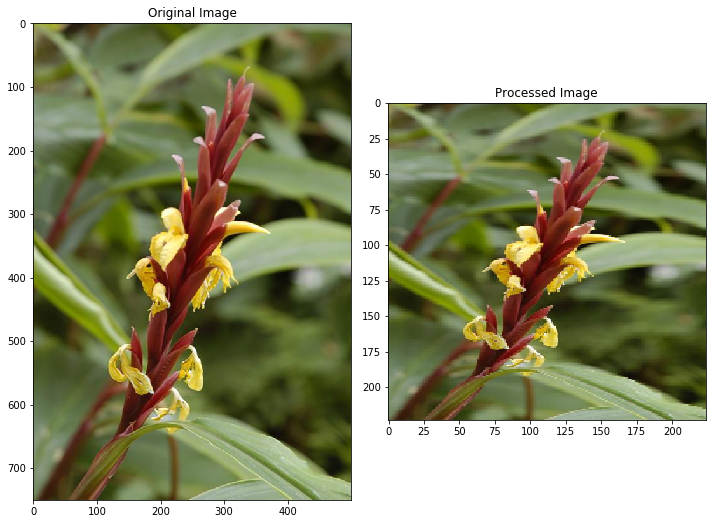

In [19]:
image_path = './test_images/cautleya_spicata.jpg'
img = Image.open(image_path)
processed_test_image = process_image(np.asarray(img))

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(np.asarray(img))
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Now, it's time to write the `predict` function for making inference with the model.

### Inference


In [20]:
# Create the predict function
# predict function
def predict(image_path, model, top_k):
    
    #reading and preprocessing the image
    img = Image.open(image_path)
    img = np.asarray(img)
    img = process_image(img)
    img = np.expand_dims(img, axis=0)

    #make prediction
    predictions = model.predict(img)

    #take top prediction probabilities
    top_probs, top_index = tf.math.top_k(predictions, top_k)

    #corresponding probabilities and classes
    probs = top_probs.numpy()[0]
    classes = top_index.numpy()[0]

    return probs , classes 

# Sanity Check

It's always good to check the predictions made by our model to make sure they are correct. To check the predictions I have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

 

Probabilities are:  [9.7049707e-01 1.2894571e-02 9.1177840e-03 1.8628770e-03 6.8806397e-04]
Classes are:  ['pink-yellow dahlia', 'fritillary', 'bolero deep blue', 'great masterwort', 'spear thistle']


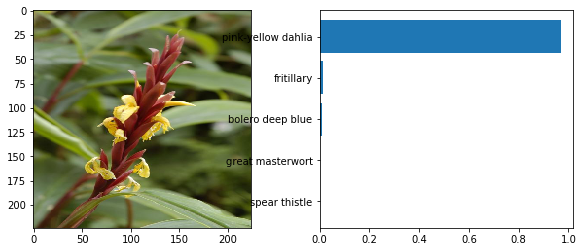

In [21]:
# Plot the input image along with the top 5 classes
image_path = './test_images/cautleya_spicata.jpg'
img = Image.open(image_path)
img = process_image(np.asarray(img))

probs, classes = predict(image_path, keras_model, 5)
classes = [class_names[str(value)] for value in classes]

print("Probabilities are: ", probs)
print("Classes are: ", classes)

fig, (ax1, ax2) = plt.subplots(figsize=(10,4), ncols=2)
ax1.imshow(img)

ax2 = plt.barh(classes[::-1], probs[::-1])

plt.show()

Probabilities are:  [9.9978346e-01 3.0325644e-05 2.6219315e-05 2.5004358e-05 2.1173317e-05]
Classes are:  ['pink primrose', 'tiger lily', 'morning glory', 'toad lily', "colt's foot"]


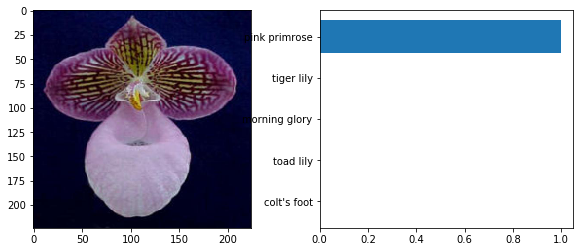

In [22]:
image_path = './test_images/hard-leaved_pocket_orchid.jpg'
img = Image.open(image_path)
img = process_image(np.asarray(img))

probs, classes = predict(image_path, keras_model, 5)
classes = [class_names[str(value)] for value in classes]

print("Probabilities are: ", probs)
print("Classes are: ", classes)

fig, (ax1, ax2) = plt.subplots(figsize=(10,4), ncols=2)
ax1.imshow(img)

ax2 = plt.barh(classes[::-1], probs[::-1])

plt.show()

Probabilities are:  [0.47815838 0.30697992 0.05305797 0.03622696 0.03229291]
Classes are:  ['geranium', 'sweet pea', 'bromelia', 'tree poppy', 'pelargonium']


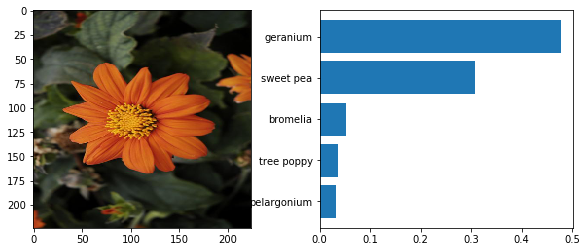

In [23]:
image_path = './test_images/orange_dahlia.jpg'
img = Image.open(image_path)
img = process_image(np.asarray(img))

probs, classes = predict(image_path, keras_model, 5)
classes = [class_names[str(value)] for value in classes]

print("Probabilities are: ", probs)
print("Classes are: ", classes)

fig, (ax1, ax2) = plt.subplots(figsize=(10,4), ncols=2)
ax1.imshow(img)

ax2 = plt.barh(classes[::-1], probs[::-1])

plt.show()

Probabilities are:  [9.9946982e-01 1.6799905e-04 1.1958892e-04 6.2798274e-05 3.7143782e-05]
Classes are:  ['petunia', 'black-eyed susan', 'peruvian lily', 'bearded iris', 'frangipani']


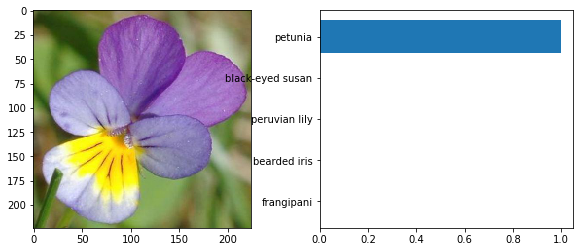

In [24]:
image_path = './test_images/wild_pansy.jpg'
img = Image.open(image_path)
img = process_image(np.asarray(img))

probs, classes = predict(image_path, keras_model, 5)
classes = [class_names[str(value)] for value in classes]

print("Probabilities are: ", probs)
print("Classes are: ", classes)

fig, (ax1, ax2) = plt.subplots(figsize=(10,4), ncols=2)
ax1.imshow(img)

ax2 = plt.barh(classes[::-1], probs[::-1])

plt.show()